In [1]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import DenseNet121
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
x = np.load('/content/drive/MyDrive/AIT 736/ND/resized_images_ND.npy')
y = np.load('/content/drive/MyDrive/AIT 736/ND/labels_ND.npy')

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

# Create DenseNet base
input_shape = x_train.shape[1:]  # Assuming x_train is a numpy array of images
input_shape

(128, 128, 3)

In [4]:
print(x_train.shape)
print(x_test.shape)

(2200, 128, 128, 3)
(550, 128, 128, 3)


In [5]:
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_ConvNeXtTiny_base(input_shape):
    # Load ConvNeXtTiny model without the top layer
    base_model = ConvNeXtTiny(include_top=False, input_shape=input_shape)

    # Perform global average pooling
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a dense layer with 125 sigmoid activated neurons
    x = Dense(125, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_classification_model(base_model, num_classes):
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # Add a dense layer with softmax activation for classification
    x = Dense(num_classes, activation='softmax')(base_model.output)

    # Create the classification model
    model = Model(inputs=base_model.input, outputs=x)

    return model

base_model = create_ConvNeXtTiny_base(input_shape)

num_classes = 5  # Change this to the number of classes in your classification task
classification_model = create_classification_model(base_model, num_classes)

classification_model.summary()


111650432/111650432 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 convnext_tiny_prestem_norm  (None, 128, 128, 3)          0         ['input_1[0][0]']             
 alization (Normalization)                                                                        
                                                                                                  
 convnext_tiny_stem (Sequen  (None, 32, 32, 96)           4896      ['convnext_tiny_prestem_normal
 tial)                                                              ization[0][0]']               
                         

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("/content/drive/MyDrive/AIT 736/ND/convnext.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = classification_model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/25
69/69 [==============================] - ETA: 0s - loss: 1.4795 - accuracy: 0.3368
Epoch 1: val_loss improved from inf to 1.37353, saving model to /content/drive/MyDrive/AIT 736/ND/convnext.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 70s 404ms/step - loss: 1.4795 - accuracy: 0.3368 - val_loss: 1.3735 - val_accuracy: 0.4345 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - ETA: 0s - loss: 1.2091 - accuracy: 0.4727
Epoch 2: val_loss improved from 1.37353 to 0.92479, saving model to /content/drive/MyDrive/AIT 736/ND/convnext.h5
69/69 [==============================] - 22s 322ms/step - loss: 1.2091 - accuracy: 0.4727 - val_loss: 0.9248 - val_accuracy: 0.6055 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - ETA: 0s - loss: 1.0642 - accuracy: 0.5477
Epoch 3: val_loss improved from 0.92479 to 0.82348, saving model to /content/drive/MyDrive/AIT 736/ND/convnext.h5
69/69 [==============================] - 24s 347ms/step - loss: 1.0642 - accuracy: 0.5477 - val_loss: 0.8235 - val_accuracy: 0.6636 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - ETA: 0s - loss: 0.9525 - accuracy: 0.5836
Epoch 4: val_loss did not improve from 0.82348
69/69 [=

In [7]:
classification_model.load_weights("/content/drive/MyDrive/AIT 736/ND/convnext.h5")
classification_model.evaluate(x_test, y_test)

18/18 [==============================] - 2s 83ms/step - loss: 0.7016 - accuracy: 0.7127


[0.7015803456306458, 0.7127272486686707]

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming classification_model.predict returns probabilities or predicted classes
y_pred = classification_model.predict(x_test)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)

# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)


18/18 [==============================] - 4s 90ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.91765   0.71560   0.80412       109
           1    0.95833   0.78632   0.86385       117
           2    0.59589   0.84466   0.69880       103
           3    0.52980   0.70796   0.60606       113
           4    0.76389   0.50926   0.61111       108

    accuracy                        0.71273       550
   macro avg    0.75311   0.71276   0.71679       550
weighted avg    0.75617   0.71273   0.71851       550



18/18 [==============================] - 3s 81ms/step


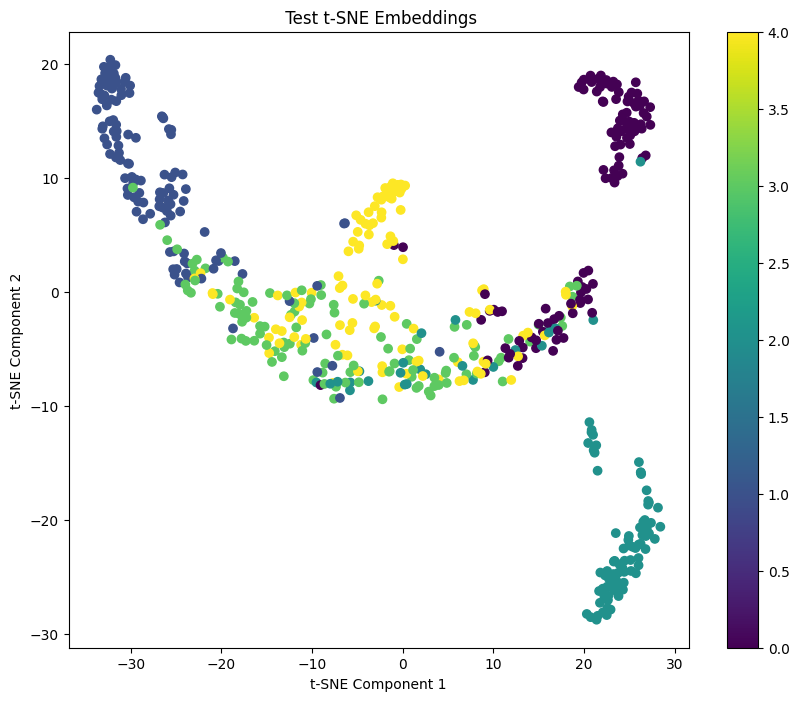

In [9]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_test_embed are the embeddings obtained from the penultimate layer
tsne = TSNE(n_components=2, random_state=42)
x_embed = base_model.predict(x_test)  # Assuming x_test is your test data
x_tsne = tsne.fit_transform(x_embed)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title(' Test t-SNE Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


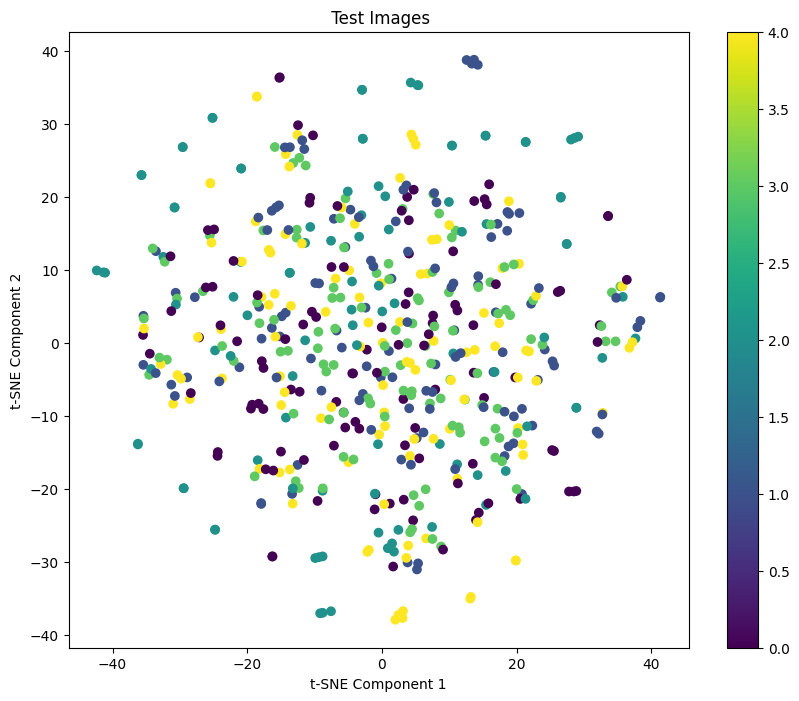

In [10]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_test_embed are the embeddings obtained from the penultimate layer
x_test_flat = x_test.reshape((550, 128*128*3))
tsne = TSNE(n_components=2, random_state=42)
#x_embed = base_model.predict(x_test)  # Assuming x_test is your test data
x_tsne = tsne.fit_transform(x_test_flat)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title(' Test Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


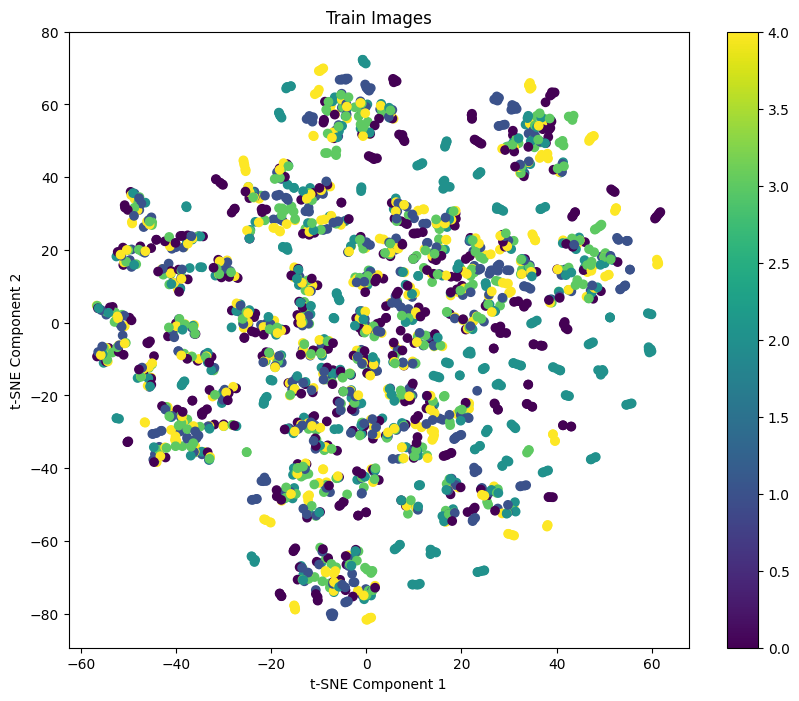

In [11]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_train_embed are the embeddings obtained from the penultimate layer
x_train_flat = x_train.reshape((2200, 128*128*3))
tsne = TSNE(n_components=2, random_state=42)
#x_embed = base_model.predict(x_train)  # Assuming x_train is your train data
x_tsne = tsne.fit_transform(x_train_flat)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('Train Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


69/69 [==============================] - 7s 104ms/step


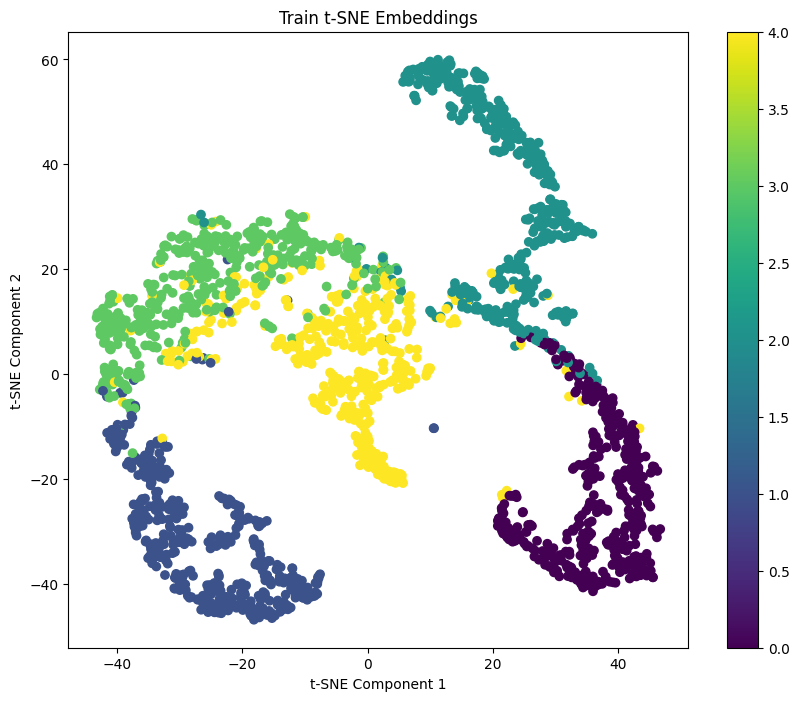

In [12]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_train_embed are the embeddings obtained from the penultimate layer
tsne = TSNE(n_components=2, random_state=42)
x_embed = base_model.predict(x_train)  # Assuming x_train is your train data
x_tsne = tsne.fit_transform(x_embed)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('Train t-SNE Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


<h1>E-Mixup

In [13]:
xtest_emb = base_model.predict(x_test)
xtrain_emb = base_model.predict(x_train)

69/69 [==============================] - 6s 83ms/step


In [14]:
import keras
y_test_o = keras.utils.to_categorical(y_test)
y_train_o = keras.utils.to_categorical(y_train)
print(y_train_o.shape)
print(y_test_o.shape)

(2200, 5)
(550, 5)


In [15]:
def mixup(xt, yt, mf):
  alp = 0.2
  xaug = []
  yaug = []
  for k in range(0,xt.shape[0]):
    cnt = 0
    for cnt in range(0,mf-1):
      lbd = np.random.beta(alp,alp)
      yks = np.random.randint(xt.shape[0])
      kdash = xt[yks]
      ydash = yt[yks]
      kdash1 = xt[k]
      ydash1 = yt[k]
      xaug1 = kdash1*lbd + kdash*(1-lbd)
      yaug1 = ydash1*lbd + ydash*(1-lbd)
      xaug.append(xaug1)
      yaug.append(yaug1)
  xs2 = np.asarray(xaug)
  ys2 = np.asarray(yaug)
  x1 = np.concatenate((xt,xs2))
  y1 = np.concatenate((yt,ys2))
  return x1,y1

In [16]:
xtrain_emb.shape

(2200, 125)

In [17]:
xtt, ytt = mixup(xtrain_emb,y_train_o,3)
xtt.shape

(6600, 125)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

Classifier_model = Sequential()
#add model layers
Classifier_model.Input = (125,)

Classifier_model.add(Dense(512,activation='relu'))
Classifier_model.add(Dense(512,activation='relu'))

Classifier_model.add(Dense(5, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
Classifier_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(xtt, ytt,epochs=25, validation_data=(xtest_emb, y_test_o))

Epoch 1/25
207/207 [==============================] - 3s 5ms/step - loss: 0.4124 - accuracy: 0.8924 - val_loss: 0.8430 - val_accuracy: 0.7055
Epoch 2/25
207/207 [==============================] - 1s 3ms/step - loss: 0.3606 - accuracy: 0.9083 - val_loss: 0.9843 - val_accuracy: 0.6855
Epoch 3/25
207/207 [==============================] - 1s 3ms/step - loss: 0.3454 - accuracy: 0.9105 - val_loss: 0.8720 - val_accuracy: 0.6927
Epoch 4/25
207/207 [==============================] - 1s 3ms/step - loss: 0.3323 - accuracy: 0.9133 - val_loss: 0.8157 - val_accuracy: 0.7127
Epoch 5/25
207/207 [==============================] - 1s 3ms/step - loss: 0.3279 - accuracy: 0.9138 - val_loss: 0.9315 - val_accuracy: 0.7000
Epoch 6/25
207/207 [==============================] - 1s 3ms/step - loss: 0.3231 - accuracy: 0.9180 - val_loss: 0.8712 - val_accuracy: 0.7091
Epoch 7/25
207/207 [==============================] - 1s 4ms/step - loss: 0.3166 - accuracy: 0.9147 - val_loss: 0.9446 - val_accuracy: 0.7164
Epoch 

In [19]:
Classifier_model.evaluate(xtest_emb, y_test_o)

18/18 [==============================] - 0s 2ms/step - loss: 1.0188 - accuracy: 0.7091


[1.0187534093856812, 0.7090908885002136]

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming Classifier_model.predict returns probabilities or predicted classes
y_pred = Classifier_model.predict(xtest_emb)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)
# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)



18/18 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.93671   0.67890   0.78723       109
           1    0.92241   0.91453   0.91845       117
           2    0.59732   0.86408   0.70635       103
           3    0.56842   0.47788   0.51923       113
           4    0.59459   0.61111   0.60274       108

    accuracy                        0.70909       550
   macro avg    0.72389   0.70930   0.70680       550
weighted avg    0.72726   0.70909   0.70871       550



E-Stitchup

In [21]:
import numpy as np

def stichup(xt, yt, mf):
    alp = 0.2
    xaug = []
    yaug = []
    for k in range(xt.shape[0]):
        for _ in range(mf-1):  # Renamed loop counter to avoid coAIT 736/NDusion with loop index
            lbd = np.random.beta(alp, alp)
            yks = np.random.randint(xt.shape[0])
            kdash = xt[yks]  # Accessing rows of xt directly
            ydash = yt[yks]  # Accessing corresponding y value
            kdash1 = xt[k]    # Accessing rows of xt directly
            ydash1 = yt[k]    # Accessing corresponding y value
            lbd_stch = int(xt.shape[1] * lbd)
            reff_stich = np.zeros(xt.shape[1])
            for i in range(lbd_stch):
                index_stich = np.random.randint(xt.shape[1])
                reff_stich[index_stich] = 1
            xaug1 = np.zeros(xt.shape[1])  # Initialize as numpy array
            for i in range(len(reff_stich)):
                if reff_stich[i] == 0:
                    xaug1[i] = kdash[i]
                else:
                    xaug1[i] = kdash1[i]
            yaug1 = ydash1 * lbd + ydash * (1 - lbd)
            xaug.append(xaug1)
            yaug.append(yaug1)
    xs2 = np.asarray(xaug)
    ys2 = np.asarray(yaug)
    x1 = np.concatenate((xt, xs2))
    y1 = np.concatenate((yt, ys2))
    return x1, y1


In [22]:
xtt, ytt = stichup(xtrain_emb,y_train_o,3)
xtt.shape

(6600, 125)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

Classifier_model = Sequential()
#add model layers
Classifier_model.Input = (125,)

Classifier_model.add(Dense(512,activation='relu'))
Classifier_model.add(Dense(512,activation='relu'))

Classifier_model.add(Dense(5, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
Classifier_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(xtt, ytt,epochs=25, validation_data=(xtest_emb, y_test_o))

Epoch 1/25
207/207 [==============================] - 2s 4ms/step - loss: 0.4956 - accuracy: 0.8445 - val_loss: 0.8557 - val_accuracy: 0.7109
Epoch 2/25
207/207 [==============================] - 1s 4ms/step - loss: 0.4376 - accuracy: 0.8618 - val_loss: 0.8332 - val_accuracy: 0.7109
Epoch 3/25
207/207 [==============================] - 1s 3ms/step - loss: 0.4228 - accuracy: 0.8702 - val_loss: 0.9240 - val_accuracy: 0.7018
Epoch 4/25
207/207 [==============================] - 1s 4ms/step - loss: 0.4073 - accuracy: 0.8723 - val_loss: 0.8568 - val_accuracy: 0.7000
Epoch 5/25
207/207 [==============================] - 1s 5ms/step - loss: 0.4045 - accuracy: 0.8742 - val_loss: 0.8604 - val_accuracy: 0.6982
Epoch 6/25
207/207 [==============================] - 1s 5ms/step - loss: 0.3892 - accuracy: 0.8802 - val_loss: 1.0326 - val_accuracy: 0.6855
Epoch 7/25
207/207 [==============================] - 1s 4ms/step - loss: 0.3744 - accuracy: 0.8865 - val_loss: 0.8758 - val_accuracy: 0.6945
Epoch 

In [24]:
Classifier_model.evaluate(xtest_emb, y_test_o)

18/18 [==============================] - 0s 2ms/step - loss: 0.9703 - accuracy: 0.6964


[0.9703282713890076, 0.696363627910614]

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming Classifier_model.predict returns probabilities or predicted classes
y_pred = Classifier_model.predict(xtest_emb)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)
# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)



18/18 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.89888   0.73394   0.80808       109
           1    0.96040   0.82906   0.88991       117
           2    0.60000   0.84466   0.70161       103
           3    0.50962   0.46903   0.48848       113
           4    0.59459   0.61111   0.60274       108

    accuracy                        0.69636       550
   macro avg    0.71270   0.69756   0.69816       550
weighted avg    0.71627   0.69636   0.69956       550

